# Financial data indices

In [183]:
import json
import math
import pandas as pd
import numpy as np

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [185]:
"""
Some saliencies are virtually 0. 
Here we filter for a given tolerance so that to avoid these values.
"""
def filter_positive(dictionary, key, tol = 0.):
    sal = dictionary[key]
    return { k: v for (k, v) in sal.items() if v > tol }

### Read data generated by .py scripts

In [186]:
with open("../data/saliency.json") as file:
    saliency = json.load(file)


summand_dws =  { key: value + saliency["ANNUAL dws b"].get(key, 0.) for key, value in saliency["ANNUAL dws"].items() }    
saliency["ANNUAL dws"] = { **saliency["ANNUAL dws b"], **summand_dws }

saliency.pop("ANNUAL dws b")

# Combine DWS-a and DWS-b

reports = list(saliency)

saliency = {company: filter_positive(saliency, company, tol=0) for company in reports}

In [187]:
types = ["ANNUAL", "RI_REPORT", "STEWARDSHIP_POLICY", "VOTING_POLICY"]
companies = set()

for report in reports:
    name = report
    for t in types:
        name = name.replace(f"{t} ", "")
        
    companies.add(name)
    
companies = list(companies)

In [188]:
companies

['blackrock', 'nbim', 'dws', 'nn', 'apg', 'generali', 'jpmam']

## Distribution of all saliencies

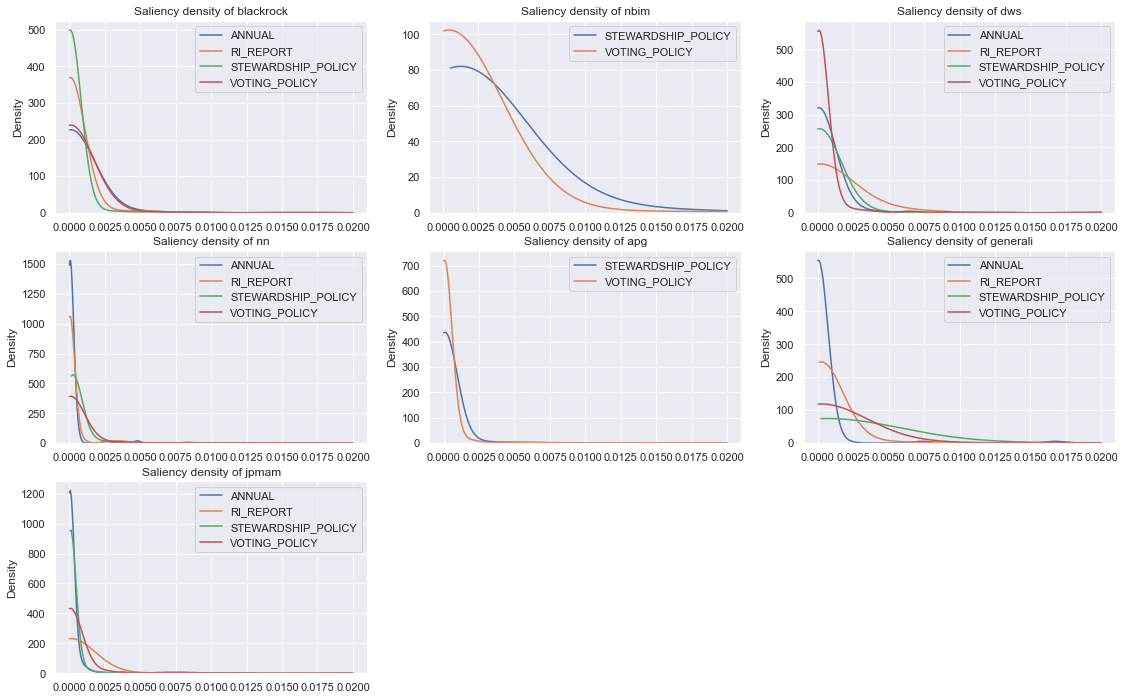

In [191]:
columns = 3
rows = math.ceil(len(companies) / columns)

fig, axes = plt.subplots(rows, columns, figsize = (19, 12))

for i, ax in enumerate(axes.flat):    
    if i < len(companies):
        company = companies[i]
        labels = []

        for t in types:
            key = f"{t} {company}"
            
            if key in saliency:
                data = list(saliency[key].values())
                lower = min(data)
                upper = .02
                
                if np.var(data) > 0:
                    sns.kdeplot(data, ax = ax, clip=(lower, upper))
                    labels.append(t)
            
        
        ax.legend(labels)
        ax.set_title(f"Saliency density of {company}")
        
    else:
        # Delete empty axes
        fig.delaxes(ax)
    
fig.savefig("../plots/saliencies_dist.pdf")

## Lenght of documents

In [169]:
groups = types

In [170]:
grouped_data = { g: {} for g in groups }

for report in reports:
    for group in groups:
        if group in report:
            company = report.replace(f"{group} ", "")
            grouped_data[group][company] = len(saliency[report])
            
            continue
            
size_df = pd.DataFrame.from_dict(grouped_data)

/var/folders/68/f6hr2xg16v980_3qg7t2l25r0000gn/T/ipykernel_97524/1032026806.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


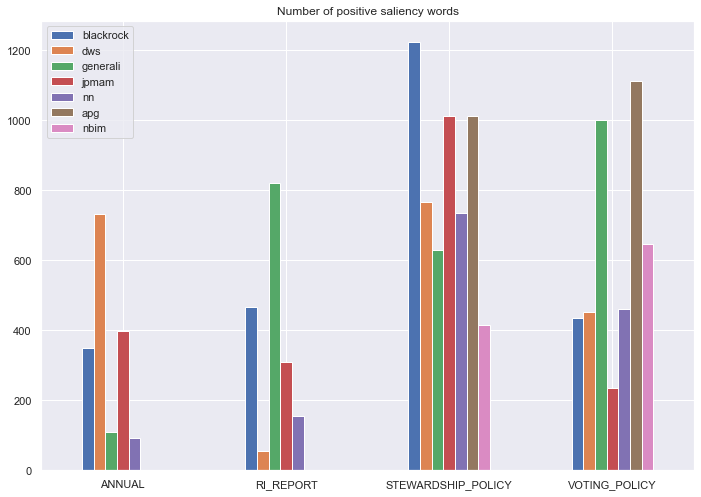

In [171]:
fig, ax = plt.subplots()

size_df.T.plot.bar(rot=0, ax=ax)
ax.set_title("Number of positive saliency words")

fig.show()
# fig.savefig("../plots/saliencies/positive_saliency.svg")

## Sustainable index, data extraction

In [194]:
broad = ["acid","rain","agroecology","air","pollution","anti-consumerist","biocapacity","biodegradable","biodegrade","biological","control","biomaterial","biome","biopiracy","bioregion","biotic","biotic","index","blue","flag","carbon","capture","carbon","credits","carbon","debt","carbon","emissions","carbon","footprint","carbon","offset","carbon","sink","carbon","tax","carbon","trading","carbon-neutral","carbon-zero","CCS","clean-air","cleantech","climate","climate","breakdown","climate","change","climate","crisis","climate","denier","climate","emergency","climate","migrant","climate","refugee","climate","strike","climate-friendly","compostable","conservancy","conservation","conserve","cryosphere","decontaminate","decontamination","defoliant","deforest","deforestation","demographic","depopulate","depopulation","disafforest","disposable","downcycle","dumping","dumping","ground", "eco-audit","eco-auditor","eco-footprint","eco-friendly","eco-label","eco-labelling","ecocide","ecolodge","ecological","ecological","footprint","ecologically","ecologist","ecology","ecoregion","ecosystem","ecotecture","ecotourism","ecotown","ecozone","emission","energy","security","energy-efficient","environment","environmental","environmentalism","environmentalist","environmentally","environmentally","friendly","exhaustible","fallout","feed-in","tariff","food","insecurity","food","security","food-insecure","freecycle","freeganism","fuel-efficient","geoengineering","global","heating","global","warming","globalization","green","green","audit","greenhouse","gas","greening","greenness","greenwash","greenwashing","grey","water","heat","sink","HEPA","filter","insolation","landfill","leachate","LEZ","life-support","system","light","pollution","litter","litterbug","low","emission","zone","low-energy","mass","extinction","natural","resources","net","zero","noise","pollution","non-renewable","NOx","nuclear","waste","nuclear","winter","off-grid","off-gridder","offset","oil","slick","oil","spill","organophosphate","over-exploitation","overpopulated","overpopulation","ozone","ozone-friendly","particulate","PCB","peak","oil","photochemical","smog","plastic","footprint","poison","pollutant","pollute","polluted","polluter","pollution","pop","populate","population","preservation","preservationist","protected","rape","reclaim","reclamation","recyclable","recycle","recycled","recycler","recycling","reduce","reduce","reuse","recycle","idiom","refuse","dump","remote","sensing","renewable","renewables","reprocess","reprocessing","reusable","rewild","rewilding","scrapyard","scrubber","season","creep","sequester","sequestration","single-use","skip","diving","slick","slow","city","smog","smoggy","solar","energy","solar","power","spillage","SSSI","sustainability","sustainable","sustainably","the","greenhouse","effect","the","National","Trust","the","ozone","layer","the","polluter","pays","principle","idiom","throwaway","tidal","power","tip","tipping","point","tree","hugger","ULEZ","unleaded","unpolluted","unsustainable","unsustainably","upcycle","upcycling","VOC","vog","water","column","zero","waste","zero-carbon"]

In [207]:
len(broad)

288

In [195]:
"""
Computes the saliency index for the words provided
"""
def index(saliency, report, words, **kwargs):
    
    def inword(k):
        for word in words:
            if word in k:
                return word
        
        return False
        
    isinwords = lambda k: any(word in k for word in words)
    
    sal = filter_positive(saliency, report, **kwargs)
    
    total = sum(sal.values())
    sustainable = { inword(k): v for (k, v) in sal.items() if inword(k) }
    
    return { "total": total, **sustainable }

In [205]:
def make_index(saliency, groups, reports, sustainable_words):

    grouped_data = { g: {} for g in groups }

    for group in groups:
        dfgroup = {}
        for report in reports:
            if group in report:
                company = report.replace(f"{group} ", "")
                dfgroup[company] = index(saliency, report, sustainable_words)

                continue

        groupdf = pd.DataFrame.from_dict(dfgroup).fillna(0.)
        groupdf.loc["s-index"] = groupdf.loc[groupdf.index != "total"].sum()
        groupdf = groupdf.drop("total", axis = 0)
        grouped_data[group] = groupdf


    df = pd.concat(grouped_data).fillna(0.)
    
    return df

In [197]:
df = make_index(saliency, groups, reports, sustainable_words)

## Sustainability index

In [203]:
total_df = df.swaplevel().loc["s-index"]

report_names = [
    "Annual report",
    "Reponsible investment report", 
    "Stewardship report", 
    "Voting policy report"
]

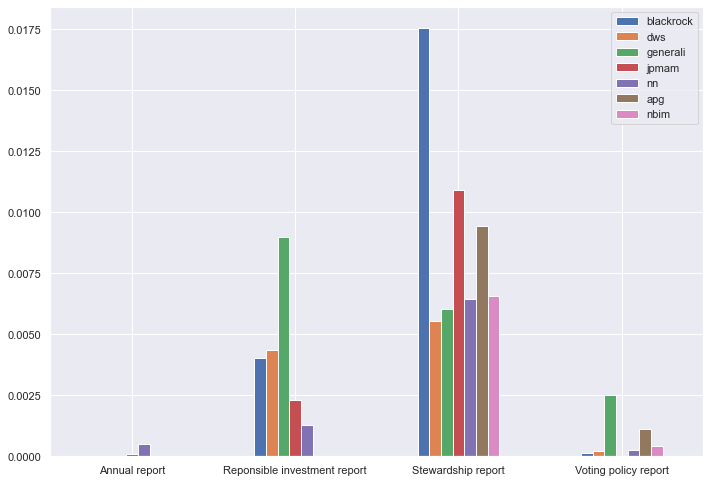

In [204]:
fig, ax = plt.subplots()

total_df.plot.bar(rot=0, ax=ax)
ax.set_xticklabels(report_names)

fig.savefig("../plots/broad_sustainable_saliency.pdf", dpi = 250)

## Index breakdown

In [193]:
word_map = [
    "environment",
    "green",
    "sustainable",
    "sustainability",
    "climate", 
]

pal = sns.color_palette("deep")

colors = {
    "environment": pal[0],
    "green": pal[2],
    "sustainable": pal[1],
    "sustainability": pal[3],
    "climate": pal[-1]
}
sns.color_palette("deep")


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

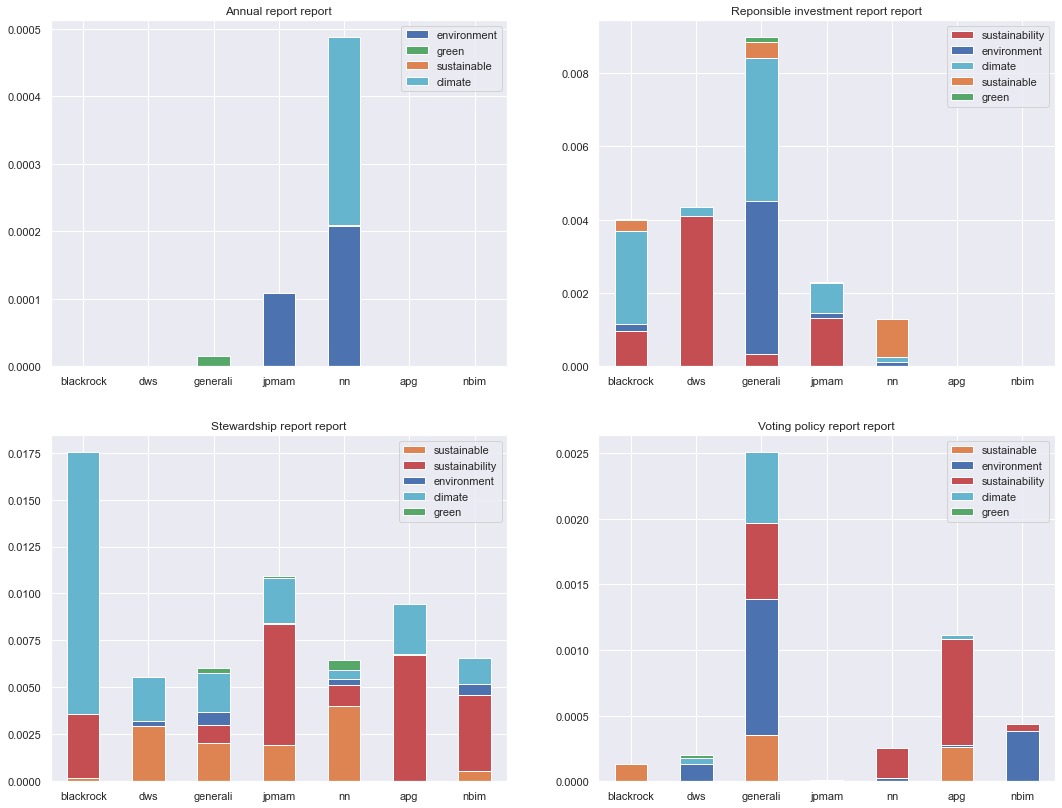

In [179]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))


for i, ax in enumerate(axes.flat):
    group = groups[i]
    group_df = df.loc[group].iloc[df.loc[group].index != "s-index"]

    group_df.T.plot(kind='bar', stacked=True, ax = ax, rot = 0, color = colors)
    ax.set_title(f"{report_names[i]} report")


fig.savefig("../plots/broad_breakdown.pdf", dpi = 250)

In [180]:
colors

{'environment': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'green': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'sustainable': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 'sustainability': (0.7686274509803922,
  0.3058823529411765,
  0.3215686274509804),
 'climate': (0.39215686274509803, 0.7098039215686275, 0.803921568627451)}

In [181]:
df.to_csv('../data/broad_saliency.csv')

In [201]:
pd.options.display.float_format = '{:.4f}'.format
df.to_latex('../data/broad_saliency.tex')

In [202]:
df

blackrock    dws  generali  jpmam     nn  \
ANNUAL             environment        0.0000 0.0000    0.0000 0.0001 0.0002   
                   green              0.0000 0.0000    0.0000 0.0000 0.0000   
                   sustainable        0.0000 0.0000    0.0000 0.0000 0.0000   
                   climate            0.0000 0.0000    0.0000 0.0000 0.0003   
                   s-index            0.0000 0.0000    0.0000 0.0001 0.0005   
RI_REPORT          sustainability     0.0009 0.0041    0.0003 0.0013 0.0000   
                   environment        0.0002 0.0000    0.0042 0.0001 0.0001   
                   climate            0.0025 0.0002    0.0039 0.0008 0.0001   
                   sustainable        0.0003 0.0000    0.0005 0.0000 0.0010   
                   green              0.0000 0.0000    0.0001 0.0000 0.0000   
                   s-index            0.0040 0.0043    0.0090 0.0023 0.0013   
STEWARDSHIP_POLICY sustainable        0.0002 0.0029    0.0021 0.0020 0.0040   
                   sustainability     0.0034 0.0000    0.0009 0.0064 0.0011   
                   environment        0.0000 0.0002    0.0007 0.0000 0.0003   
                   climate            0.0140 0.0024    0.0021 0.0024 0.0005   
                   green              0.0000 0.0000    0.0003 0.0001 0.0005   
                   s-index            0.0175 0.0055    0.0060 0.0109 0.0064   
VOTING_POLICY      sustainable        0.0001 0.0000    0.0004 0.0000 0.0000   
                   environment        0.0000 0.0001    0.0010 0.0000 0.0000   
                   sustainability     0.0000 0.0000    0.0006 0.0000 0.0002   
                   climate            0.0000 0.0000    0.0005 0.0000 0.0000   
                   green              0.0000 0.0000    0.0000 0.0000 0.0000   
                   s-index            0.0001 0.0002    0.0025 0.0000 0.0003   

                                     apg   nbim  
ANNUAL             environment    0.0000 0.0000  
                   green          0.0000 0.0000  
                   sustainable    0.0000 0.0000  
                   climate        0.0000 0.0000  
                   s-index        0.0000 0.0000  
RI_REPORT          sustainability 0.0000 0.0000  
                   environment    0.0000 0.0000  
                   climate        0.0000 0.0000  
                   sustainable    0.0000 0.0000  
                   green          0.0000 0.0000  
                   s-index        0.0000 0.0000  
STEWARDSHIP_POLICY sustainable    0.0000 0.0006  
                   sustainability 0.0067 0.0040  
                   environment    0.0000 0.0006  
                   climate        0.0027 0.0014  
                   green          0.0000 0.0000  
                   s-index        0.0094 0.0066  
VOTING_POLICY      sustainable    0.0003 0.0000  
                   environment    0.0000 0.0004  
                   sustainability 0.0008 0.0001  
                   climate        0.0000 0.0000  
                   green          0.0000 0.0000  
                   s-index        0.0011 0.0004